<h2><center>Analysis: Extending starmap to support the anisotropic radiative transfer equation (ARTE)</center></h2>

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt
from shtools import *
from starmap import *
init_shtools()
starmap = Starmap3D(order=4)

This notebook analyses and discusses the implications of changing the underlying transport transport equation for the starmap solver from the isotropic RTE to ARTE.

The underlying $P_N$-equations for the original starmap solver are derived from the moment expansion of the RTE. These generally consist of terms with the form

$$
A\vec{u}\left( \vec{x}\right)
$$

where $\vec{u}$ is the vector of all expansion coefficients of the radiance field at location $\vec{x}$. The matrix $A$ expresses how these coefficients depend on each other. It therefore models the coupling between coefficients.

The structure of these matrices $A$ is crucial for the staggered grid approach of Starmap. In particular, a core principle is the decoupling of the coefficients into two disjoint sets, denoted even and odd:

$$
\vec{u} =
\left(
\begin{array}
.\vec{u}^\mathbf{e}\\
0
\end{array}
\right)
+\left(
\begin{array}
.0\\
\vec{u}^\mathbf{o}
\end{array}
\right)
$$

This allows to formulate a time-stepping procedure, where the even components are updated using only the odd components and vice versa. During update step, one set of components is assumed constant throughout the timestep.

For brevity, we will skip discussing the procedure for assigning coefficients to the even/odd set. The following plot visualizes the final assignment:



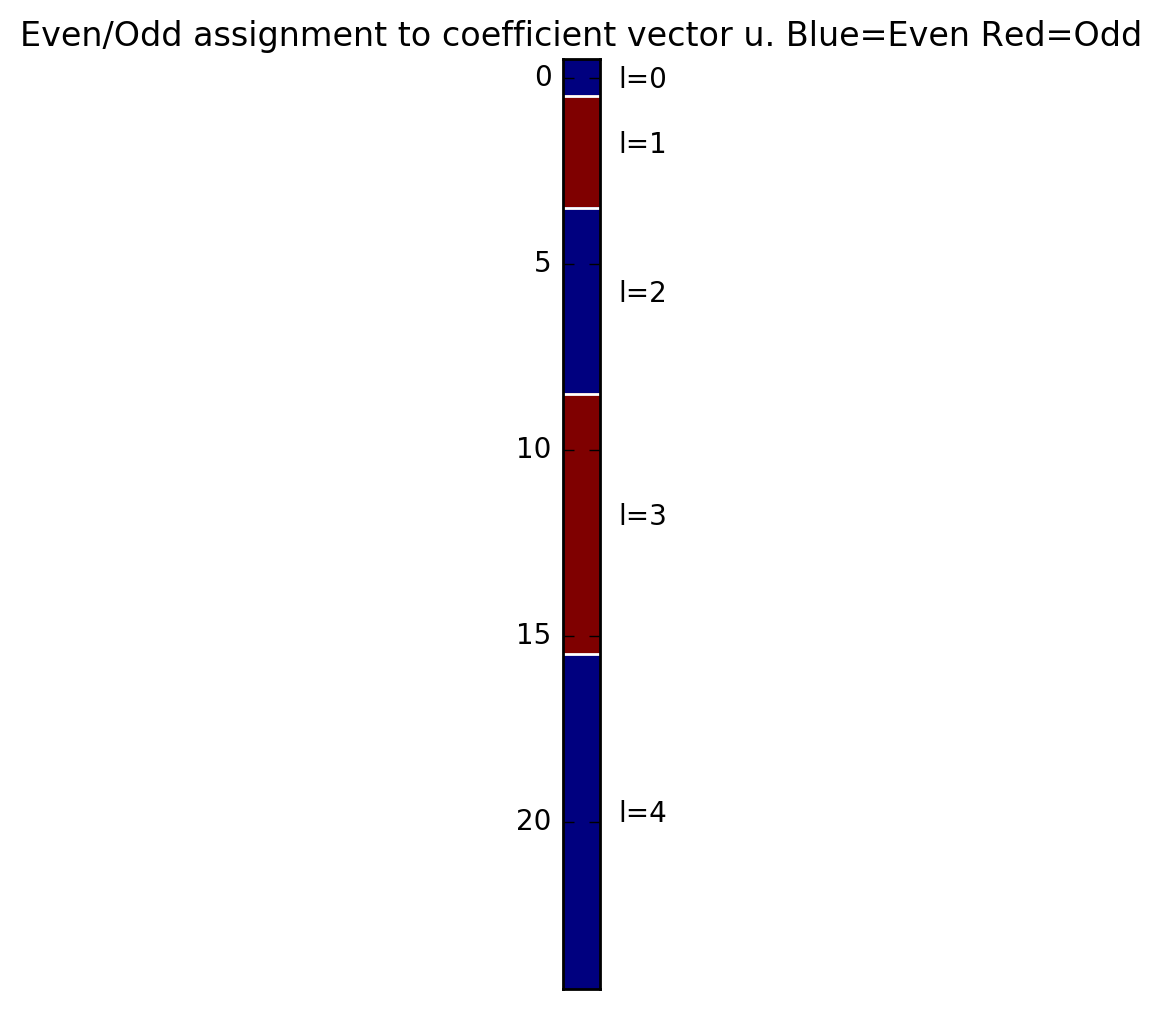

In [2]:
u_even_odd_assignment = np.zeros( (starmap.numCoeffs, 1) )
for c in range(starmap.numCoeffs):
    if starmap.sga.is_odd(c):
        u_even_odd_assignment[c,0] = 1.0
    else:
        u_even_odd_assignment[c,0] = 0.0
fig = plt.figure(figsize=(6, 6))
#plt.title( "$M_{s_{real}}$ SGGX phase function" )
plt.imshow(np.abs(u_even_odd_assignment), interpolation='nearest', vmin=0.0, vmax=1.0)
plt.title("Even/Odd assignment to coefficient vector u. Blue=Even Red=Odd")
for l in range(starmap.N):
    numCoeffsPerBand = numSHCoeffs(l)
    plt.axhline(numCoeffsPerBand-0.5, color='w')
    #plt.axhline(numCoeffsPerBand-0.5, color='w')
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.annotate('l=0', xy=(0.2, 0.5), xytext=(1, 0.25))
ax.annotate('l=1', xy=(0.2, 2.0), xytext=(1, 2))
ax.annotate('l=2', xy=(0.2, 6.0), xytext=(1, 6))
ax.annotate('l=3', xy=(0.2, 12.0), xytext=(1, 12))
ax.annotate('l=4', xy=(0.2, 20.0), xytext=(1, 20))
plt.show()


The first important observation is, that the even/odd assignment coincides with the SH bands of the coefficients. All coefficients of the same band $l$ are either all even or all odd. Further, the assignment alternates for successive bands. All coefficients of band zero are even, of band one are odd, of band two are even, etc.

### Matrix $M$
The original Starmap problem introduces the following coupling matrices: $M_x$, $M_y$, $M_z$ and $C$. The $M$ matrices come from the SH expansion of the directional derivative term $(\omega\cdot\nabla)L$. The matrix $C$ comes from the SH expansion of the extinction and scattering term. Let us first visualize $M_x$ to see its structure($M_y$ and $M_z$ are similar):

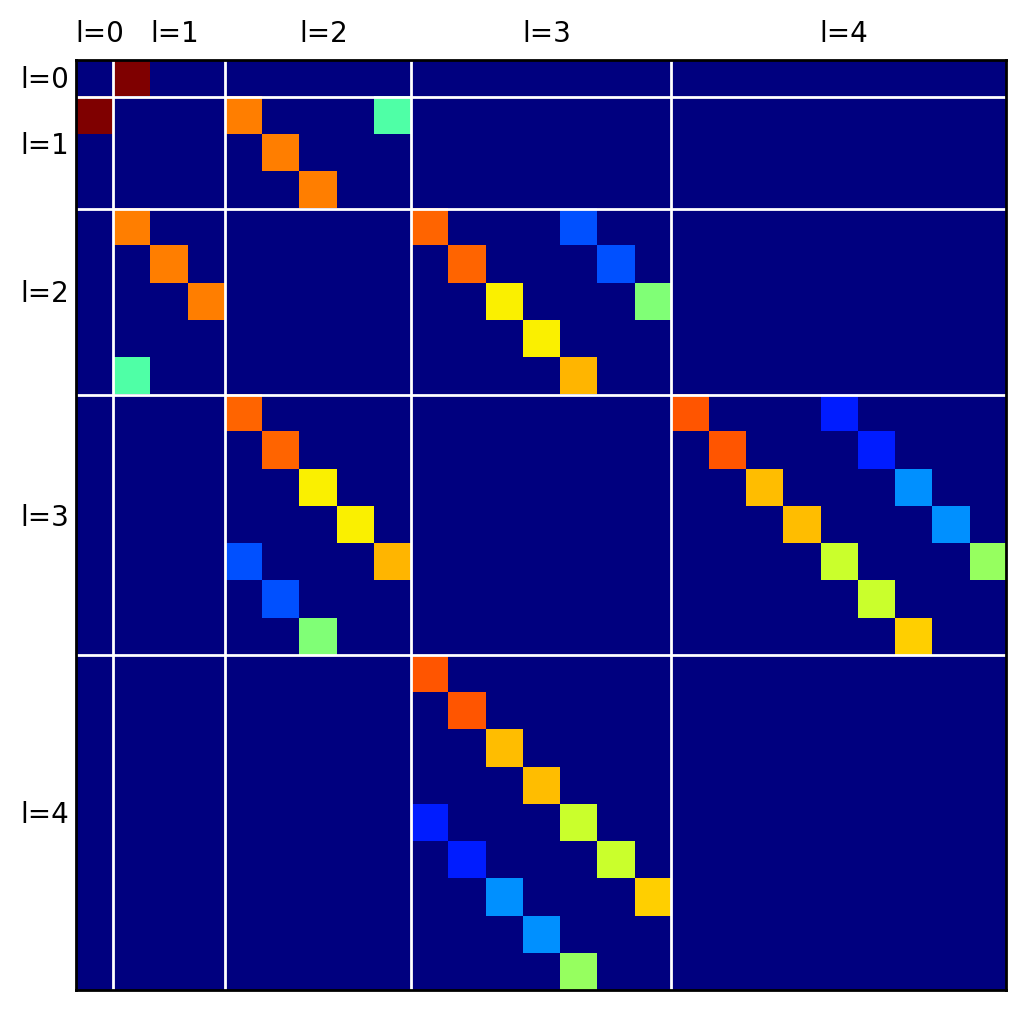

In [20]:
def plot_matrix( size, M ):
    global starmap
    fig = plt.figure(figsize=(size, size))
    ax = plt.gca()
    plt.imshow(M, interpolation='nearest', vmin=0.0, vmax=np.max(M))
    for l in range(starmap.N):
        numCoeffsPerBand = numSHCoeffs(l)
        plt.axvline(numCoeffsPerBand-0.5, color='w')
        plt.axhline(numCoeffsPerBand-0.5, color='w')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.annotate('l=0', xy=(0.2, 0.5), xytext=(-2, 0.25))
    ax.annotate('l=1', xy=(0.2, 2.0), xytext=(-2, 2))
    ax.annotate('l=2', xy=(0.2, 6.0), xytext=(-2, 6))
    ax.annotate('l=3', xy=(0.2, 12.0), xytext=(-2, 12))
    ax.annotate('l=4', xy=(0.2, 20.0), xytext=(-2, 20))

    ax.annotate('l=0', xy=(0.2, 0.5), xytext=(-0.5, -1))
    ax.annotate('l=1', xy=(0.2, 2.0), xytext=(1.5, -1))
    ax.annotate('l=2', xy=(0.2, 6.0), xytext=(5.5, -1))
    ax.annotate('l=3', xy=(0.2, 12.0), xytext=(11.5, -1))
    ax.annotate('l=4', xy=(0.2, 20.0), xytext=(19.5, -1))
    plt.show()
    
plot_matrix(6.0, np.abs(starmap.Mx_real))

In the visualization of $M_x$ above, we see that $M_x$ is sparse. We further see, that $M_x$ has a checkerboard structure of non-zero and zero coefficients. *This is actually not important*.

The white lines seperate the coefficients into the different SH bands and from that we further see that $M_x$ has also a block-checkerboard structure. That is, blocks with non-zero coefficients alternate with blocks of zero-coefficients. *This structure is what is really important here*. We see that the coefficients of even bands ($l=0,2,4$ etc.) *only* depend on coefficients of odd bands ($l=1,3$ etc.) and vice versa. Since band-structure and even/odd-assignment are the same, this means that with our matrix $M_x$, even coefficients are only coupled with odd coefficients and vice versa. The same is true for $M_y$ and $M_z$.

### Matrix $C$
Now let us take a look at matrix $C$ in the original Starmap implementation. This matrix represents the effect on the solution vector $u$ from extinction and scattering. In case of the isotropic radiative transfer equation, it is a simple diagonal matrix:

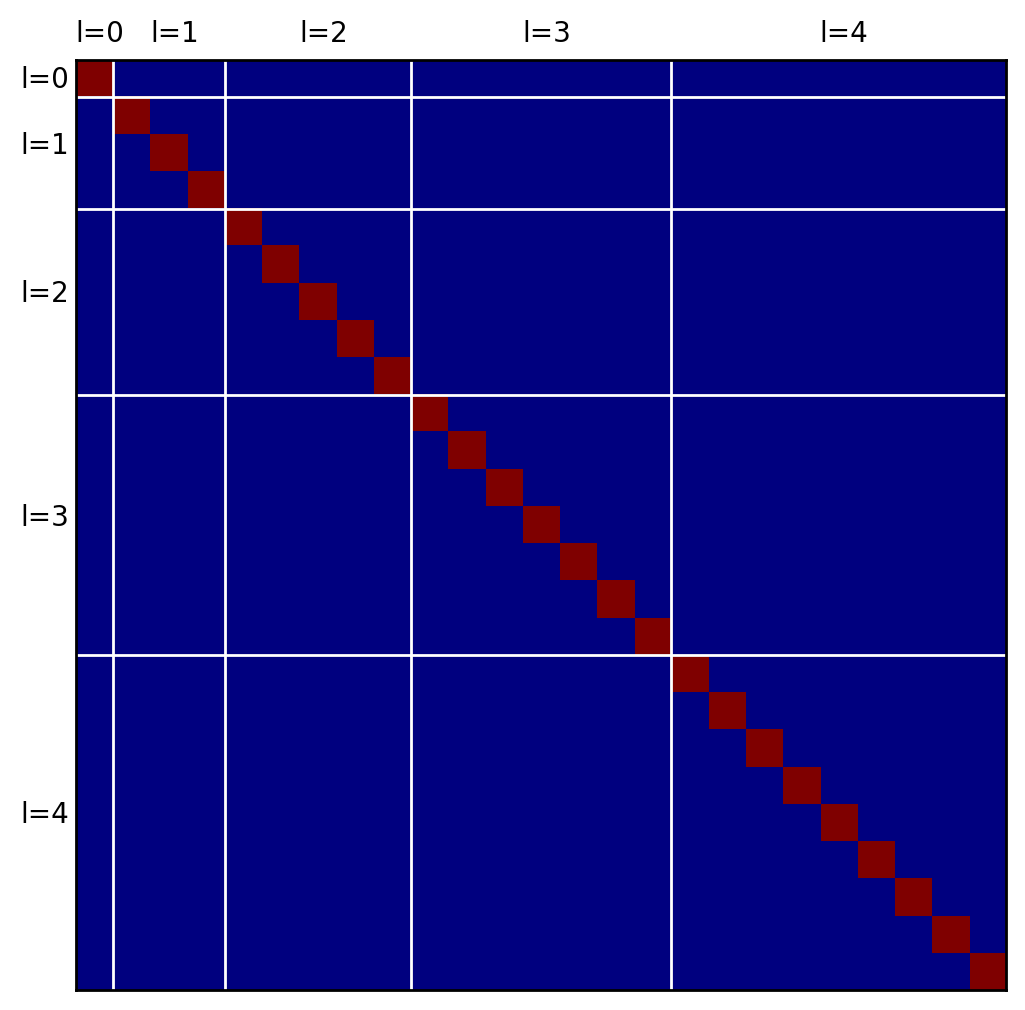

In [12]:
plot_matrix(6.0, np.diag(np.ones(starmap.numCoeffs)))

With this matrix $C$, we have the problem that the time evolution of each SH coefficient is coupled with itsself. However, since the matrix is diagonal, the problem can be solved by allowing this term in the final differential equation which expresses the time evolution of a single coefficient:

$$
\partial_t u^{lm}(\vec{x}, t) + c^{lm}(\vec{x})u^{lm}(\vec{x}, t) = r^{lm}(\vec{x})
$$

Here, $u^{lm}$ is the coefficient to be updated, $c^{lm}$ is the main diagonal entry of $C$, which is associated with coefficent index $lm$ and $r^{lm}$ is a term which contains all the dependencies for updating $u^{lm}$. Due to the structure of $M_x$, $M_y$ and $M_z$, $r^{lm}$ will only contain odd coefficients when $u^{lm}$ is even and vice versa. These dependencies are assumed constant across the timestep $\Delta t$ for which $u^{lm}$ is updated.

### Matrix $M_s$ from anisotropic radiative transfer equation

Now with a good understanding of coupling matrices and the importance of their structure to the staggered grid method, we will now look at the matrix $M_s$, which is received from doing the SH expansions of the scattering term in the ARTE. The expansion has been derived in the scattering term section in starmap_extensions.ipynb.

The structure of $M_x$, $M_y$ and $M_z$ is independent of location and time. This is different for the matrices $C$ and $M_s$. Their structure depends on the phase function, which can vary with position. For our analysis, we will use the SH representation of the SGGX phase function (see sggx_sh.ipynb for details).

Using the phase function coefficients, we will compute the coefficients of $M_s$ according to the expression which has been derived in starmap_extensions.ipynb:

$$
\sum_{l_3}\sum_{m_3=-l_3}^{l_3}
\left(
\sum_{m_1=-l_1}^{l_3}
f_p^{l_3m_1lm}\left(\vec{x}\right)
\left(-1\right)^{m_1}\delta_{(m_1+m_3)0}
\right)
L^{l_3m_3}(\vec{x})
$$

This gives us the complex version for all coefficients going from $m=-l$ to $m=l$. As with $M_x$, $M_y$ and $M_z$, we will transform this matrix into real variables representing the real and imaginary parts of coefficients from $m=0$ to $m=l$. This  transformation is represented by $S$ (see details in the Starmap paper). Such a transformation was not necessary for $C$, since $C$ was diagonal and therefore the transformation would have had no effect.


In [13]:
def build_Ms_complex( phase, order ):
    Ms_complex = np.zeros( (numSHCoeffs(order),numSHCoeffs(order)), dtype=complex )
    # build scattering matrix by iterating over each l, m-row (associated with SH equation l,m)
    for l in range(order+1):
        for m in range(-l, l+1):
            sh_index = shIndex(l, m)
            # no evaluate the ansiostropic scattering term Eq. derived in starmap_extensions.ipynb
            for l3 in range(order+1):
                for m3 in range(-l3, l3+1):
                    sh_index_3 = shIndex(l3, m3)
                    coeff = np.complex(0.0, 0.0)
                    for m1 in range(-l3, l3+1):
                        sh_index_31 = shIndex(l3, m1)
                        # this if clause realizes the delta function in the term
                        if m1+m3 == 0:
                            coeff += phase.P[sh_index_31, sh_index]*np.power(-1.0, m1)
                    Ms_complex[sh_index, sh_index_3] = coeff
    return Ms_complex

phase_iso = PhaseFunctionSH("starmap_extensions_arte_study/phase_iso.sh")
phase_hg = PhaseFunctionSH("starmap_extensions_arte_study/phase_hg.sh")
phase_sggx = PhaseFunctionSH("starmap_extensions_arte_study/phase_sggx.sh")

Ms_complex_iso = build_Ms_complex(phase_iso, starmap.N)
Ms_complex_hg = build_Ms_complex(phase_hg, starmap.N)
Ms_complex_sggx = build_Ms_complex(phase_sggx, starmap.N)

# compute real valued scattering matrices 
Ms_real_iso = np.real(starmap.S.dot(Ms_complex_iso.dot(starmap.S_inv)))
Ms_real_hg = np.real(starmap.S.dot(Ms_complex_hg.dot(starmap.S_inv)))
Ms_real_sggx = np.real(starmap.S.dot(Ms_complex_sggx.dot(starmap.S_inv)))

We now visualize the structure of $M_s$ for the three different phase functions. In order to make their structure more apparent, we will apply a threshold and quantize the coefficients to zero and one accordingly:

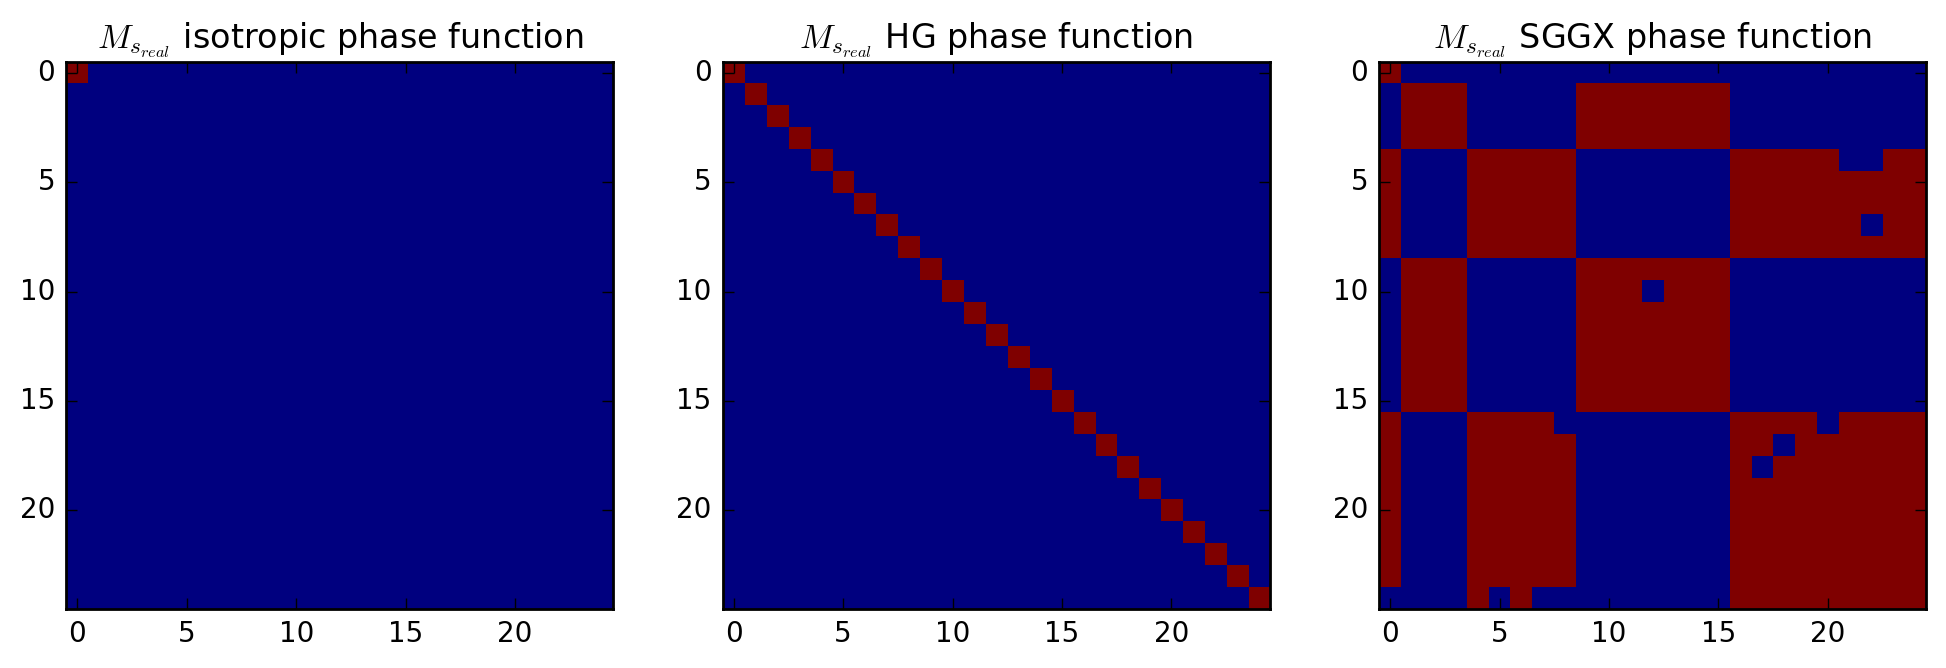

In [19]:
threshold = 1.0e-3
Ms_complex_iso[np.abs(Ms_complex_iso) > threshold] = 1.0
Ms_complex_iso[np.abs(Ms_complex_iso) <= threshold] = 0.0

Ms_complex_hg[np.abs(Ms_complex_hg) > threshold] = 1.0
Ms_complex_hg[np.abs(Ms_complex_hg) <= threshold] = 0.0

Ms_complex_sggx[np.abs(Ms_complex_sggx) > threshold] = 1.0
Ms_complex_sggx[np.abs(Ms_complex_sggx) <= threshold] = 0.0

Ms_real_iso[np.abs(Ms_real_iso) > threshold] = 1.0
Ms_real_iso[np.abs(Ms_real_iso) <= threshold] = 0.0

Ms_real_hg[np.abs(Ms_real_hg) > threshold] = 1.0
Ms_real_hg[np.abs(Ms_real_hg) <= threshold] = 0.0

Ms_real_sggx[np.abs(Ms_real_sggx) > threshold] = 1.0
Ms_real_sggx[np.abs(Ms_real_sggx) <= threshold] = 0.0

# now we visualize the matrices again
vmax = 1.0
fig = plt.figure(figsize=(12, 12))
ax = plt.subplot( 131 )
plt.title( "$M_{s_{real}}$ isotropic phase function" )
plt.imshow(np.abs(Ms_real_iso), interpolation='nearest', vmin=0.0, vmax=vmax)
ax = plt.subplot( 132 )
plt.title( "$M_{s_{real}}$ HG phase function" )
plt.imshow(np.abs(Ms_real_hg), interpolation='nearest', vmin=0.0, vmax=vmax)
ax = plt.subplot( 133 )
plt.title( "$M_{s_{real}}$ SGGX phase function" )
plt.imshow(np.abs(Ms_real_sggx), interpolation='nearest', vmin=0.0, vmax=vmax)
plt.show()

In the plots above we see that the isotropic phase function only produces a single coefficient at $l=0$ and $m=0$. A rotationally invariant phase function (which only depends on angle between $\omega_i$ and $\omega_o$) produces a diagonal matrix. This is the diagonalization of the scattering operator, which was mentioned in the Starmap-paper and which makes $C$ diagonal. The matrix $M_s$ is much more dense but still reveals a block-checkerboard structure similar to matrices $M_x$, etc.

Let us take a closer look at $M_s$ for the SGGX phase function:

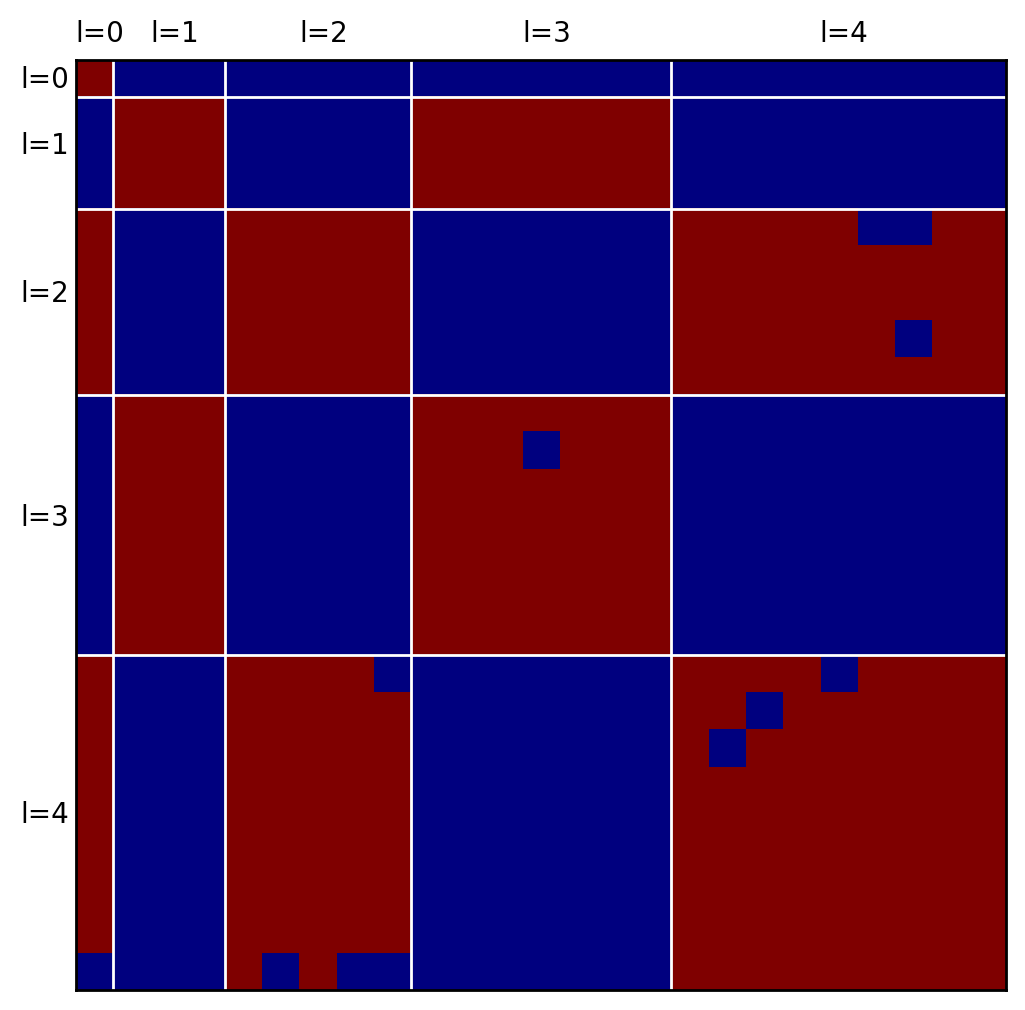

In [21]:
plot_matrix(6.0, Ms_real_sggx)

Here we see that for general phase functions, $M_s$ has a similar block-checkerboard pattern as $M_x$, with the important difference, that for the scattering term, even bands only depend on even bands and odd bands only depend on odd bands. Therefore we have a violation of the important criteria that even coefficients only depend on odd coefficients and vice verse. For scattering, this is the opposite. Even coefficients depend on even coefficients.

### solution approach

#### 1.
We could seperate $M_s$ into $M_s = C\vec{u} + C_s{u}$. Then we could still formulate a time update rule like:

$$
\partial_t u^{lm}(\vec{x}, t) + c^{lm}(\vec{x})u^{lm}(\vec{x}, t) + C_s^{lm}(\vec{x})u(\vec{x}, t) = r^{lm}(\vec{x})
$$

The question now would be: Is it ok to assume even/odd coefficents in C_s to be constant when updating even/odd coefficients $u^{lm}$?

#### 2.
It may actually be possible to still solve the matrix-ODE using matrix exponentials, when $C$ ($M_s$) is not diagonal. This requires more investigation.